In [2]:
# !pip install prophet statsmodels

In [3]:
# !pip install pandas gspread google-auth google-auth-oauthlib google-auth-httplib2 google-api-python-client

#### Importing Libraries

In [4]:
import pandas as pd
import os
import glob
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

#### Loading Data

In [5]:
import os
os.getcwd()

'c:\\Users\\Hannah\\Desktop\\DS_Y3S1\\DSCP\\Asg2\\GitHub_Compost_Anomaly'

In [6]:
import os
import pandas as pd
import gspread
from google.oauth2.service_account import Credentials
from googleapiclient.discovery import build
from googleapiclient.errors import HttpError

def create_gspread_client(credentials_path):

    scope = ["https://spreadsheets.google.com/feeds", "https://www.googleapis.com/auth/drive"]
  
    creds = Credentials.from_service_account_file(credentials_path, scopes=scope)
    
    # Authorize the gspread client
    client = gspread.authorize(creds)
    return client

def authenticate_drive(credentials_path):

    scope = ["https://spreadsheets.google.com/feeds", "https://www.googleapis.com/auth/drive"]
    
    # Load the credentials
    creds = Credentials.from_service_account_file(credentials_path, scopes=scope)
    
    # Build the Google Drive service
    drive_service = build('drive', 'v3', credentials=creds)
    return drive_service

def get_sheets_in_folder(drive_service, folder_id):
    query = f"'{folder_id}' in parents and mimeType='application/vnd.google-apps.spreadsheet'"
    results = drive_service.files().list(q=query, pageSize=1000, fields="files(id, name)").execute()
    items = results.get('files', [])
    print(items)
    return items

def read_and_concat_sheets(client, file_id):
    spreadsheet = client.open_by_key(file_id)
    all_sheets_data = []
    for sheet in spreadsheet.worksheets():
        sheet_data = pd.DataFrame(sheet.get_all_records())
        print(sheet_data.shape)
        sheet_name = sheet.title
        print("Sheet Name:", sheet_name)
        all_sheets_data.append(sheet_data)
        # print(len(all_sheets_data[0]))
    return pd.concat(all_sheets_data, ignore_index=True)

# Main script to load and concatenate all sheets from all Google Sheets in the folder
def load_and_concat_all_sheets_in_centers(base_directory_id, credentials_path):
    try:
        client = create_gspread_client(credentials_path)
        drive_service = authenticate_drive(credentials_path)
        
        all_data = []
        
        center_folders = drive_service.files().list(q=f"'{base_directory_id}' in parents and mimeType='application/vnd.google-apps.folder'",
                                                    fields="files(id, name)").execute().get('files', [])
        
        for center_folder in center_folders:
            sheet_files = get_sheets_in_folder(drive_service, center_folder['id'])
            for sheet_file in sheet_files:
                sheet_data = read_and_concat_sheets(client, sheet_file['id'])
                sheet_data['Location'] = center_folder['name'].split('_')[1]
                all_data.append(sheet_data)
        
        return pd.concat(all_data, ignore_index=True)
    except HttpError as error:
        print(f"An error occurred: {error}")
        return None

# Example usage
base_directory_id = '1uH8e33HJQG4v8BmCZ_EJYmGH-VmWI547'  # The ID of the main folder containing center folders
credentials_path = r'C:\Users\Hannah\Desktop\DS_Y3S1\DSCP\Asg2\streamlit_npkcomposter_anomaly\streamlit-npkcomposter-anomaly-71e49f3f60a9.json'
all_data = load_and_concat_all_sheets_in_centers(base_directory_id, credentials_path)
print(all_data.shape)


[{'id': '1fhf6gdJ3Fy0Lorazknh8IXiGFxLJI9b8RRjRnOcbWHs', 'name': 'Sengkang_Rack (Jan - Jun 2024)'}]
(19, 16)
Sheet Name: 2 Apr 2024
(19, 16)
Sheet Name: 9 Apr 2024
(20, 16)
Sheet Name: 16 Apr 2024
(20, 16)
Sheet Name: 23 Apr 2024
(20, 16)
Sheet Name: 30 Apr 2024
(21, 16)
Sheet Name: 3 May 2024
(25, 16)
Sheet Name: 5 May 2024
(21, 16)
Sheet Name: 6 May 2024
(21, 16)
Sheet Name: 11 May 2024
(21, 16)
Sheet Name: 14 May 2024
(21, 16)
Sheet Name: 19 May 2024
(28, 16)
Sheet Name: 21 May 2024
(23, 16)
Sheet Name: 23 May 2024
[]
[]
[]
[]
[]
[]
[]
[]
[{'id': '1z873cO3CtP4_3uOwwZndfZzfv3JR3jnlafoguT5Fa30', 'name': '01 MacPherson_Rack (22 Dec 2023 to 18 Apr 2024)'}, {'id': '1_xMxiCynn_lMKSOghh0Ac757ORldPCNUJyaoRudX1nI', 'name': '02 MacPherson_Rack (01 May 2024 to 06 Jun 2024)'}]
(809, 17)
Sheet Name: 22 December 2023
(809, 16)
Sheet Name:  23 December 2023
(800, 16)
Sheet Name: 30 December 2023
(818, 16)
Sheet Name: 5 April 2024
(999, 17)
Sheet Name: 6 April 2024
(516, 18)
Sheet Name: 10 April 202

In [7]:
pd.set_option('display.max_column', None)
all_data.head()

,Timestamp,Number of Worms,Phosphorous01,Phosphorous02,Nitrogen01,Nitrogen02,Potassium01,Potassium02,Light Intensity,Temp01,Hum01,Heat01,SoilM01,SoilM02,Grams of Compost Harvested,Remarks,Location,Number of Worms (non-counted),Buzzer (NIL),,Buzzer,Compost Notes,pH Rod 1,pH Rod 2
0,"2 Apr 2024, 3:30 PM",15,0,,0,,0,,43,28.9,76,51,0,,,Harvest compost,SengKang,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"2 Apr 2024, 3:40 PM",15,0,,0,,0,,43,28.9,77,52,0,,,,SengKang,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"2 Apr 2024, 3:50 PM",15,0,,0,,0,,43,28.7,76,52,0,,,,SengKang,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"2 Apr 2024, 4:00 PM",15,0,,0,,0,,44,28.9,77,52,0,,,,SengKang,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"2 Apr 2024, 4:10 PM",15,0,,0,,0,,45,28.7,77,52,0,,,,SengKang,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5886 entries, 0 to 5885
Data columns (total 24 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   Timestamp                      5886 non-null   object
 1   Number of Worms                279 non-null    object
 2   Phosphorous01                  5886 non-null   object
 3   Phosphorous02                  5886 non-null   object
 4   Nitrogen01                     5886 non-null   object
 5   Nitrogen02                     5886 non-null   object
 6   Potassium01                    5886 non-null   object
 7   Potassium02                    5886 non-null   object
 8   Light Intensity                1104 non-null   object
 9   Temp01                         5886 non-null   object
 10  Hum01                          5886 non-null   object
 11  Heat01                         5886 non-null   object
 12  SoilM01                        5886 non-null   object
 13  Soi

#### Missing Rows Handling

In [9]:
# Create a copy of the original DataFrame
filtered_data = all_data.copy()

# Calculate the threshold for dropping columns
threshold = len(filtered_data) * 0.5

# Iterate over each column
for column in filtered_data.columns:
    # Calculate the percentage of NaN values in the column
    nan_percentage = filtered_data[column].isna().mean()
    
    # If NaN percentage >= 50%, drop the column
    if nan_percentage >= 0.5:
        filtered_data.drop(column, axis=1, inplace=True)

# Print the updated DataFrame shape
print("Shape after dropping columns with NaN or null values >= 50%:", filtered_data.shape)


Shape after dropping columns with NaN or null values >= 50%: (5886, 15)


In [10]:
filtered_data.head()

,Timestamp,Phosphorous01,Phosphorous02,Nitrogen01,Nitrogen02,Potassium01,Potassium02,Temp01,Hum01,Heat01,SoilM01,SoilM02,Grams of Compost Harvested,Location,Number of Worms (non-counted)
0,"2 Apr 2024, 3:30 PM",0,,0,,0,,28.9,76,51,0,,,SengKang,NaN
1,"2 Apr 2024, 3:40 PM",0,,0,,0,,28.9,77,52,0,,,SengKang,NaN
2,"2 Apr 2024, 3:50 PM",0,,0,,0,,28.7,76,52,0,,,SengKang,NaN
3,"2 Apr 2024, 4:00 PM",0,,0,,0,,28.9,77,52,0,,,SengKang,NaN
4,"2 Apr 2024, 4:10 PM",0,,0,,0,,28.7,77,52,0,,,SengKang,NaN


In [11]:
filtered_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5886 entries, 0 to 5885
Data columns (total 15 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   Timestamp                      5886 non-null   object
 1   Phosphorous01                  5886 non-null   object
 2   Phosphorous02                  5886 non-null   object
 3   Nitrogen01                     5886 non-null   object
 4   Nitrogen02                     5886 non-null   object
 5   Potassium01                    5886 non-null   object
 6   Potassium02                    5886 non-null   object
 7   Temp01                         5886 non-null   object
 8   Hum01                          5886 non-null   object
 9   Heat01                         5886 non-null   object
 10  SoilM01                        5886 non-null   object
 11  SoilM02                        5886 non-null   object
 12  Grams of Compost Harvested     5886 non-null   object
 13  Loc

1. Calculate the NPK Ratio using the ideal 4:2:1 ratio as a reference.
2. Anomaly Detection using Prophet.
3. Time Series Analysis for NPK Ratio Trends.
4. Regression Analysis with Random Forest Regressor.

#### Data Type fix

In [12]:
filtered_data = filtered_data[filtered_data['Timestamp'].str.contains('Unit') == False]
filtered_data = filtered_data[filtered_data['Timestamp'].notna()]

In [14]:
columns_to_convert = ['Phosphorous01', 'Phosphorous02', 'Nitrogen01', 'Nitrogen02', 
                        'Potassium01', 'Potassium02', 'Temp01', 'Hum01', 'Heat01', 
                        'SoilM01', 'SoilM02', 'Grams of Compost Harvested', 'Number of Worms (non-counted)']

# Attempt to convert to float, replacing non-numeric values with NaN
filtered_data[columns_to_convert] = filtered_data[columns_to_convert].apply(pd.to_numeric, errors="coerce")

# Check the data types
print(filtered_data.dtypes)
print(filtered_data.info())

Timestamp                         object
Phosphorous01                    float64
Phosphorous02                    float64
Nitrogen01                       float64
Nitrogen02                       float64
Potassium01                      float64
Potassium02                      float64
Temp01                           float64
Hum01                            float64
Heat01                           float64
SoilM01                          float64
SoilM02                          float64
Grams of Compost Harvested       float64
Location                          object
Number of Worms (non-counted)    float64
dtype: object
<class 'pandas.core.frame.DataFrame'>
Int64Index: 5881 entries, 0 to 5885
Data columns (total 15 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Timestamp                      5881 non-null   object 
 1   Phosphorous01                  4947 non-null   float64
 2   Phosphorous02      

#### Missing Columns Handling

In [15]:
# Calculate the threshold for dropping columns
threshold = len(filtered_data) * 0.5

# Iterate over each column
for column in filtered_data.columns:
    # Calculate the percentage of NaN values in the column
    nan_percentage = filtered_data[column].isna().mean()
    
    # If NaN percentage >= 50%, drop the column
    if nan_percentage >= 0.5:
        filtered_data.drop(column, axis=1, inplace=True)

# Print the updated DataFrame shape
print("Shape after dropping columns with NaN or null values >= 50%:", filtered_data.shape)


Shape after dropping columns with NaN or null values >= 50%: (5881, 14)


#### Feature Engineering

In [16]:
# Feature Engineering

filtered_data['Timestamp'] = pd.to_datetime(filtered_data['Timestamp'])
filtered_data['Hour'] = filtered_data['Timestamp'].dt.hour
filtered_data['Minute'] = filtered_data['Timestamp'].dt.minute

# NPK Ratio Class
# creating the NPKRatio since it isnt a column
# nitrogen phosphorus and potassium are input features
class NPKRatio:
    def __init__(self, phosphorous, nitrogen, potassium):
        self.phosphorous = phosphorous
        self.nitrogen = nitrogen
        self.potassium = potassium
    
    # a scaling method
    # ppm value is higher for the npk values to scale it down
    # if phosphorus == 0, it returns 0. we want it to scale it without returning a number hence this
    def calculate_ratio(self):
        if self.phosphorous == 0:
            return 0
        return (self.nitrogen / 4 + self.potassium / 1) / (self.phosphorous / 2)

# Calculate NPK Ratio
def calculate_npk_ratio(row):
    npk = NPKRatio(row['Phosphorous01'], row['Nitrogen01'], row['Potassium01'])
    return npk.calculate_ratio()

#### Forecasting

Index(['Timestamp', 'Phosphorous01', 'Phosphorous02', 'Nitrogen01',
       'Nitrogen02', 'Potassium01', 'Potassium02', 'Temp01', 'Hum01', 'Heat01',
       'SoilM01', 'SoilM02', 'Location', 'Number of Worms (non-counted)',
       'Hour', 'Minute', 'NPK_Ratio'],
      dtype='object')
Index(['ds', 'y'], dtype='object')


19:00:53 - cmdstanpy - INFO - Chain [1] start processing
19:00:54 - cmdstanpy - INFO - Chain [1] done processing


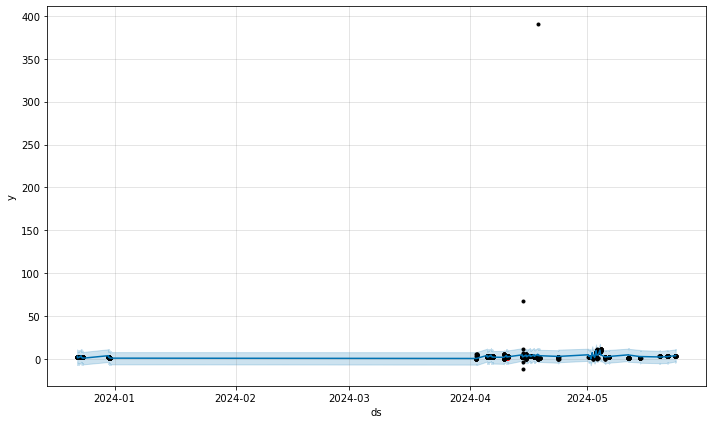

In [17]:
filtered_data['NPK_Ratio'] = filtered_data.apply(calculate_npk_ratio, axis=1)
print(filtered_data.columns)

# Anomaly Detection with Prophet
filtered_data_prophet = filtered_data[['Timestamp', 'NPK_Ratio']].rename(columns={'Timestamp': 'ds', 'NPK_Ratio': 'y'})
print(filtered_data_prophet.columns)
model = Prophet()
model.fit(filtered_data_prophet)
future = model.make_future_dataframe(periods=0)
forecast = model.predict(future)
filtered_data['yhat'] = forecast['yhat']
filtered_data['yhat_lower'] = forecast['yhat_lower']
filtered_data['yhat_upper'] = forecast['yhat_upper']
filtered_data['Anomaly'] = (filtered_data['NPK_Ratio'] < filtered_data['yhat_lower']) | (filtered_data['NPK_Ratio'] > filtered_data['yhat_upper'])
anomalies = filtered_data[filtered_data['Anomaly']]

# Plot Prophet results with anomalies
fig = model.plot(forecast)
plt.scatter(anomalies['Timestamp'], anomalies['NPK_Ratio'], color='red')
plt.show()

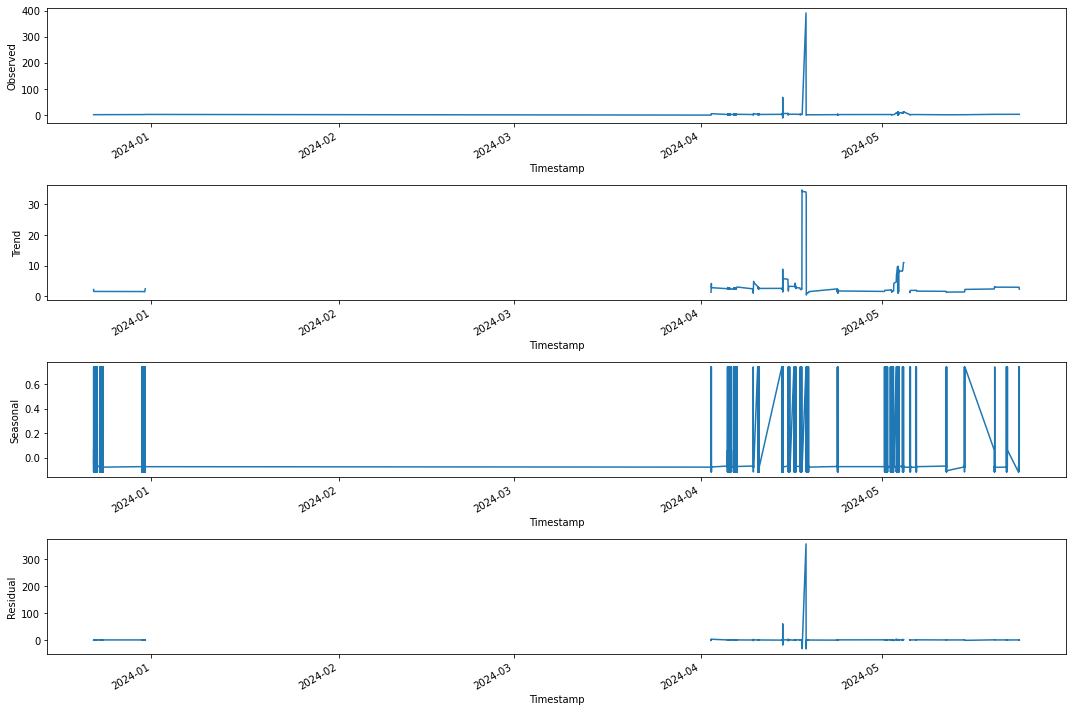

In [18]:
# Set 'Timestamp' as index
filtered_data.set_index('Timestamp', inplace=True)

# Handle missing values by interpolation
filtered_data['NPK_Ratio'] = filtered_data['NPK_Ratio'].interpolate(method='linear')

# Perform time series decomposition
result = seasonal_decompose(filtered_data['NPK_Ratio'], model='additive', period=12)

# Plot the results with increased width
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 10))
result.observed.plot(ax=ax1, legend=False)
ax1.set_ylabel('Observed')
result.trend.plot(ax=ax2, legend=False)
ax2.set_ylabel('Trend')
result.seasonal.plot(ax=ax3, legend=False)
ax3.set_ylabel('Seasonal')
result.resid.plot(ax=ax4, legend=False)
ax4.set_ylabel('Residual')
plt.tight_layout()
plt.show()

In [19]:
filtered_data.head()

,Phosphorous01,Phosphorous02,Nitrogen01,Nitrogen02,Potassium01,Potassium02,Temp01,Hum01,Heat01,SoilM01,SoilM02,Location,Number of Worms (non-counted),Hour,Minute,NPK_Ratio,yhat,yhat_lower,yhat_upper,Anomaly
Timestamp,,,,,,,,,,,,,,,,,,,,
2024-04-02 15:30:00,0.0,NaN,0.0,NaN,0.0,NaN,28.9,76.0,51.0,0.0,NaN,SengKang,NaN,15.0,30.0,0.0,3.057961,-3.967306,10.605902,False
2024-04-02 15:40:00,0.0,NaN,0.0,NaN,0.0,NaN,28.9,77.0,52.0,0.0,NaN,SengKang,NaN,15.0,40.0,0.0,3.022113,-4.412833,10.228238,False
2024-04-02 15:50:00,0.0,NaN,0.0,NaN,0.0,NaN,28.7,76.0,52.0,0.0,NaN,SengKang,NaN,15.0,50.0,0.0,2.986564,-4.731436,10.654329,False
2024-04-02 16:00:00,0.0,NaN,0.0,NaN,0.0,NaN,28.9,77.0,52.0,0.0,NaN,SengKang,NaN,16.0,0.0,0.0,2.951319,-4.536686,10.528674,False
2024-04-02 16:10:00,0.0,NaN,0.0,NaN,0.0,NaN,28.7,77.0,52.0,0.0,NaN,SengKang,NaN,16.0,10.0,0.0,2.916381,-4.399950,10.483652,False


In [20]:
# Regression with Random Forest
features = filtered_data[['Phosphorous01', 'Nitrogen01', 'Potassium01', 'Temp01', 'Hum01', 'Heat01', 'SoilM01', 'Hour', 'Minute']]
target = filtered_data['NPK_Ratio']
features.fillna(features.mean(), inplace=True)
target.fillna(target.mean(), inplace=True)
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print()
print(f"Random Forest Regressor: MSE = {mse:.2f}, R2 = {r2:.2f}")

# Decision Tree Regressor
dt = DecisionTreeRegressor(random_state=42)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)
mse_dt = mean_squared_error(y_test, y_pred_dt)
r2_dt = r2_score(y_test, y_pred_dt)
print("\nDecision Tree Regressor:")
print(f"MSE = {mse_dt:.2f}, R2 = {r2_dt:.2f}")

# Other Models
models = {'Ridge': Ridge(), 'Lasso': Lasso(), 'ElasticNet': ElasticNet()}
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results[name] = {'MSE': mse, 'R2': r2}
for name, metrics in results.items():
    print(f"{name}: MSE = {metrics['MSE']:.2f}, R2 = {metrics['R2']:.2f}")

C:\Users\Hannah\AppData\Local\Temp\ipykernel_20604\1845557103.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features.fillna(features.mean(), inplace=True)



Random Forest Regressor: MSE = 0.11, R2 = 0.91

Decision Tree Regressor:
MSE = 0.07, R2 = 0.94
Ridge: MSE = 0.82, R2 = 0.34
Lasso: MSE = 1.25, R2 = -0.01
ElasticNet: MSE = 1.19, R2 = 0.03


#### Pickling

In [ ]:
import pickle
with open('random_forest_regressor.pkl', 'wb') as f:
    pickle.dump(rf, f)

In [21]:
import pickle
with open('dt_regressor.pkl', 'wb') as f:
    pickle.dump(dt, f)

In [22]:
import joblib
import numpy
import PIL
import h5py
import sklearn
import tensorflow
import keras
import streamlit

print("joblib version:", joblib.__version__)
print("numpy version:", numpy.__version__)
print("Pillow version:", PIL.__version__)
print("h5py version:", h5py.__version__)
print("scikit-learn version:", sklearn.__version__)
print("tensorflow version:", tensorflow.__version__)
print("keras version:", keras.__version__)
print("streamlit version:", streamlit.__version__)

joblib version: 1.3.2
numpy version: 1.26.4
Pillow version: 9.0.1
h5py version: 3.11.0
scikit-learn version: 1.2.2
tensorflow version: 2.16.1
keras version: 3.3.3
streamlit version: 1.31.0
